# Students performance in exams
## Javier A. Tiniaco Leyba

 I will be predicting math scoring of student. Dataset taken from [here](https://www.kaggle.com/spscientist/students-performance-in-exams).
 
 It is important to notice that I will suppose that reading and writing scores are not available to predict the math score, since in reality we would not know those scores, because they are usually published together.

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# load data
data = pd.read_csv('StudentsPerformance.csv')

##  Exploratory analysis
Let's perform some basic descriptive statistics to understand the dataset.

In [3]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Let's make sure there are no missing values, and impute them ih there are.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


We can see from above that there are no missing values, also, we have 1000 samples.

### Explore each feature
Since there are only a few features, we can explore them all manually to understand the distribution of each feature, which will be useful to choose how to make then normalization. We will ignore scoring for now since those are numeric features, and explre first the categorical ones.

In [5]:
features = [data[feat].unique() for feat in data.keys()]

In [6]:
# Show categorical features, ignore numeric ones
features[:-3]

[array(['female', 'male'], dtype=object),
 array(['group B', 'group C', 'group A', 'group D', 'group E'],
       dtype=object),
 array(["bachelor's degree", 'some college', "master's degree",
        "associate's degree", 'high school', 'some high school'],
       dtype=object),
 array(['standard', 'free/reduced'], dtype=object),
 array(['none', 'completed'], dtype=object)]

Simple anonymous function to plot features in a bar graph.

In [7]:
barplot = lambda text: data[text].value_counts().plot(kind='bar'); plt.show();

##### Gender

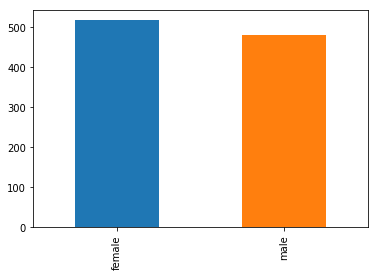

In [8]:
barplot('gender')
plt.show()

In [9]:
data['gender'].value_counts()

female    518
male      482
Name: gender, dtype: int64

Gender seem to be balanced in the data. So the the feature can be encoded as a binary variable, with two values: {0,1}

##### Race/ethnicity

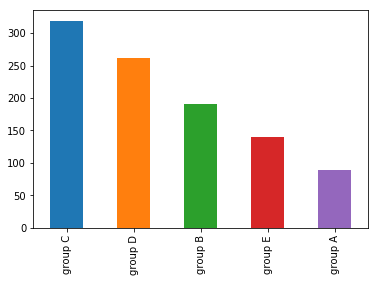

In [10]:
barplot('race/ethnicity')
plt.show()

In [11]:
data['race/ethnicity'].value_counts()

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64

In this case, we see that groups are distributed linearly, so we can normalize this feature linearly.

#### parental level of education

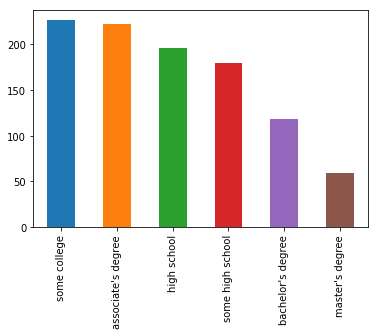

In [12]:
barplot('parental level of education')
plt.show()

In [13]:
data['parental level of education'].value_counts()

some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64

This is not linear but it could be approximated as such, since there are no wild variations, but we can also try a parabolic normalization or a gaussian, which seems to fit best the data.

#### lunch

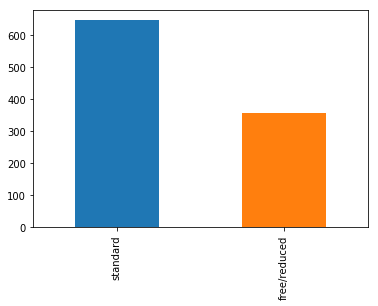

In [14]:
barplot('lunch')
plt.show()

In [15]:
data['lunch'].value_counts()

standard        645
free/reduced    355
Name: lunch, dtype: int64

The class is not balanced but, we can codify it by a binary variable, since we only have two classes:

#### test preparation course

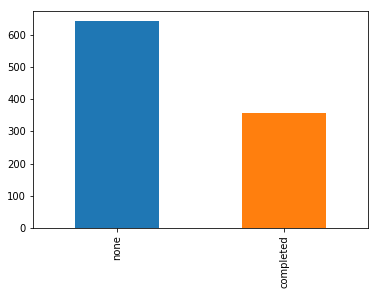

In [16]:
barplot('test preparation course')
plt.show()

In [17]:
data['test preparation course'].value_counts()

none         642
completed    358
Name: test preparation course, dtype: int64

Unbalanced, binary feature that can be codified as a binary number.

### Fetures to numeric data
Now that we know how the features are distributed, we need to codify them so that the neural network can work. First, we will make a deepcopy of the original dataframe to avoid damaging the data.

In [18]:
# default copy of DataFrame object is deep
num_data = data.copy()

In [19]:
num_data['gender'].replace({'male':1, 'female':-1}, inplace=True)

num_data['lunch'].replace({'standard':1, 'free/reduced':-1}, inplace=True)

num_data['test preparation course'].replace({'completed':1, 'none':-1}, inplace=True)

num_data['parental level of education'].replace({
    "master's degree":0, 
    "bachelor's degree":1,
    'some high school':2,
    'high school':3,
    "associate's degree":4,
    'some college':5}, inplace=True)

num_data['race/ethnicity'].replace({
    'group A':0, 
    'group E':1,
    'group B':2,
    'group D':3,
    'group C':4}, inplace=True)

Now we have the data with numeric values, but we need to normallize, because the convergence of neural networks is usually improved when data is normalized. The only features left to normalize are "race/ethnicity" and "parental level of education".

In [20]:
num_data.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,-1,2,1,1,-1,72,72,74
1,-1,4,5,1,1,69,90,88
2,-1,2,0,1,-1,90,95,93
3,1,0,4,-1,-1,47,57,44
4,1,4,5,1,-1,76,78,75


### Normalization

In [21]:
def linear_normalization(vector):
    """Vector is a numpy 1D array"""
    mean = vector.mean()
    interval = vector.max() - vector.min()
    return (vector - mean) / interval

In [22]:
X = np.array(num_data.iloc[:,:5]).astype(np.float)
Y = np.array(data['math score'])

In [23]:
X[:,1] = linear_normalization(X[:,1])

In [24]:
X[:,2] = linear_normalization(X[:,2])

## Modeling

I decided to use keras because the data is simple, so there is no need to craft optimizers or loss functions. If it were necesarry, tensorflow would be a better option, because it is a low level library. 

 Notice that since we hava few samples, we are using MSE as loss function, even though mean squared logarithmic error (MSLE) is usually preferable for regression problems. I am doing this because MLSE is makes it harder for the NN to converge, which is a problem when there are few samples.

#### Spliting train, test sets

40% of the samples are kept for testing, and a random state set for reproducibility.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

#### Actual NN model, simple MLP
Since the problem is simple, a multilayer perceptron is good enought to obtain decent results. I am following the [Occam's razor principle](https://en.wikipedia.org/wiki/Occam%27s_razor) here.

In [26]:
def MLP(optimizer = 'sgd', loss = 'mean_squared_error', drop=0.25, neurons=20, activation = 'sigmoid'):
    model = Sequential([
        # Careful, overfit
        Dropout(drop),
        Dense(neurons, input_shape=(5,)),
        # Activations: 'tanh', 'sigmoid', 'relu'
        Activation(activation),
        Dense(1)
        # Activation('relu'),
        ])

    model.compile(optimizer=optimizer,
                  loss=loss)
    return model

In [27]:
model = MLP('sgd', 'mean_squared_error')

#### Model training

In [28]:
model.fit(X_train, y_train, epochs=25, verbose=1)

Epoch 1/25
600/600 [==============================] - 1s 2ms/step - loss: 970.5844
Epoch 2/25
600/600 [==============================] - 0s 142us/step - loss: 210.6462
Epoch 3/25
600/600 [==============================] - 0s 138us/step - loss: 214.0251
Epoch 4/25
600/600 [==============================] - 0s 143us/step - loss: 212.7119
Epoch 5/25
600/600 [==============================] - 0s 190us/step - loss: 214.4375
Epoch 6/25
600/600 [==============================] - 0s 163us/step - loss: 213.2297
Epoch 7/25
600/600 [==============================] - 0s 142us/step - loss: 216.4873
Epoch 8/25
600/600 [==============================] - 0s 145us/step - loss: 205.3999
Epoch 9/25
600/600 [==============================] - 0s 138us/step - loss: 218.4415
Epoch 10/25
600/600 [==============================] - 0s 147us/step - loss: 214.9469
Epoch 11/25
600/600 [==============================] - 0s 158us/step - loss: 205.4049
Epoch 12/25
600/600 [==============================] - 0s 150us/s

## Model evaluation

In [29]:
# predictions
y_pred = model.predict(X_test)

Visual way of checking results. A clear linear relation means better results, since predictions are closer to real values.

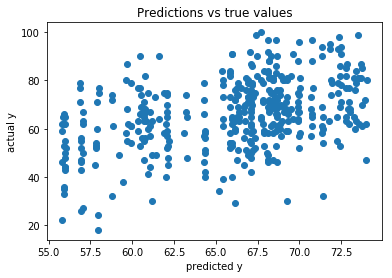

In [30]:
plt.scatter(y_pred, y_test);
plt.xlabel('predicted y')
plt.ylabel('actual y')
plt.title('Predictions vs true values')
plt.show()

Calculate test MSE.

In [31]:
test_mse = mean_squared_error(y_pred, y_test)
test_mse

178.0899131270697

At this point the model is scoring better in the test set than in the training set, probably due to underfitting since I used only 25 epochs and NN parameters were not tuned, since it was not the purpose of this analysis. However, tje results obtained are already decent.

In [32]:
corr = np.corrcoef([y_pred.flatten(),y_test])
corr

array([[1.        , 0.42449272],
       [0.42449272, 1.        ]])

A correlation between predictions and true values of 0.42 is obtained, which is ceirtanly not great, but is ok if we consider that we only have 5 predictors for a complex problem, for which we lack information.

### Model interpretability

A very simple shallow Neural Network was used with only a few parameters. 

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


Knowledge can be extracted from the weights of the NN first layer.

In [34]:
first_layer_weights = model.get_weights()[0]

In [35]:
first_layer_weights.shape

(5, 20)

20 weights per each of the 5 features. We can obtain the relative importance of each feature by taking the mean of the weights.

In [36]:
mean_weights = first_layer_weights.mean(axis=1)

In [37]:
mean_weights

array([ 0.14077069, -0.29328525, -0.03074291,  0.4732377 ,  0.24500763],
      dtype=float32)

In [38]:
weights_features = {key:val for (key,val) in zip(data.keys()[:5],mean_weights) }
weights_features

{'gender': 0.14077069,
 'race/ethnicity': -0.29328525,
 'parental level of education': -0.030742913,
 'lunch': 0.4732377,
 'test preparation course': 0.24500763}

From the weights of the first layer we can see that the parental level of education is considered less important than the preparation and surprisingly, the type of lunch they had. Moreover, from the weights of the gender feature, it seems like males are more likely to obtain a higher score than females. However, data is not enought to make any conclusion, statistical testing wold be necessary. The results of the weights can serve only as a guideline for further analysis.